### WLLS_I_estimator.ipynb
- Siep Dokter
- Emil Jousimaa
- Oleksandr Sosovskyy
- Mario Gabriele Carofano

> This file contains the implementation of 2 alternative WLLS estimators, named OS-WLLS_I (One Step) and TS-WLLS_I (Two Step), as requested in the 4th task, used for estimate the Target Coordinates starting from the RSS information coming from the anchors.

> In addition, at the end of file, there are also plots showing the actual position of the target and the anchors, and the estimated position of the target obtained from the execution of the 2 estimators.

In [1]:
# IMPORTS
import import_ipynb
import constants
import auxfunc
import sys
import pandas as pd
import numpy as np
import pprint
import math

importing Jupyter notebook from constants.ipynb
importing Jupyter notebook from auxfunc.ipynb


In [2]:
def calculate_AI_matrix(anchor_coords):
	'''
	Calculates the 'AI' matrix of the system of equations [R2, eq. (9)] which the OS_WLLS_I method solves.
	This is the implementation of [R2, eq. (10)].

	Parameters:
	anchor_coords (list) : A list containing one list for each anchor, e.g. the 2D-coordinates of each anchor.

	Returns:
	Returns a 2D numpy.ndarray which values
	are elements of the 'AI' matrix for the selected scenario.
	'''

	n_anchors = len(anchor_coords)
	A = np.zeros((n_anchors, 3))

	for i in range(n_anchors):
		A[i, 0] = -2 * anchor_coords[i][0]
		A[i, 1] = -2 * anchor_coords[i][1]
		A[i, 2] = 1

	return A

In [3]:
def calculate_bI_vector(anchor_coords, estimated_distances):
	'''
	Calculates the 'bI' vector of the system of equations [R2, eq. (9)] which the OS_WLLS_I method solves.
	This is the implementation of [R2, eq. (10)].

	Parameters:
	anchor_coords (list) : A list containing one list for each anchor, e.g. the 2D-coordinates of each anchor.
	estimated_distances (list):
	A list containing one real number for each anchor,
	e.g. the distance estimation between each anchor and the target.

	Returns:
	Returns a 1D numpy.ndarray which values
	are elements of the 'bII' vector for the selected configuration.
	'''

	n_anchors = len(anchor_coords)
	b = []

	for i in range(n_anchors):
		sqr_distance = math.pow(estimated_distances[i], 2)
		sqr_x = math.pow(anchor_coords[i][0], 2)
		sqr_y = math.pow(anchor_coords[i][1], 2)
		b.append(sqr_distance - sqr_x - sqr_y)
		i = i + 1
	
	return np.array(b)

In [4]:
def calculate_CI_matrix(estimated_distances):
	'''
	Calculates, for the selected configuration, the 'CI' diagonal matrix.

	Parameters:
	estimated_distances (list):
	A list containing one real number for each anchor,
	e.g. the distance estimation between each anchor and the target.

	Returns:
    Returns a 2D numpy.ndarray which values are elements
    of the 'CI' covariance diagonal matrix for the selected configuration.
	'''

	# This is the implementation of [R2, eq. (18)].
	# covariance = []
	# variance = math.pow(constants.STANDARD_DEVIATION, 2)

	# for d in estimated_distances:
	# 	sqr_distance = math.pow(d, 2)
	# 	covariance.append(variance * sqr_distance)
	
	# return 4 * np.diag(covariance)

	# This is the implementation of [R2-6, eq. (3.156)].
	weights = []
	variance = math.pow(constants.STANDARD_DEVIATION, 2)
	sqr_path_loss = math.pow(constants.PATH_LOSS_EXPONENT, 2)

	for d in estimated_distances:
		num = math.exp(4 * d / constants.PATH_LOSS_EXPONENT)
		den = 1 - math.exp(-4 * variance / sqr_path_loss)
		weights.append(num/den)

	return np.diag(weights)

In [5]:
def calculate_Lambda_WLLS_matrix(AI, bI, CI):
	'''
	Calculates the Weighted Linear Least Squares (WLLS) position estimate.
	This is the implementation of [R2-6, eq. (3.141)].

	Parameters:
	AI (numpy.ndarray): Matrix AI.
	bI (numpy.ndarray): Vector bI.
	CI (numpy.ndarray): Weight matrix CI.

	Returns:
	Returns the OS_WLLS_I position estimate.
	'''

	AI_transpose = np.transpose(AI)
	# CI_inverse = np.linalg.inv(CI)
	CI_inverse = CI
	
	left_term = np.linalg.inv(np.matmul(np.matmul(AI_transpose, CI_inverse), AI))
	right_term = np.matmul(np.matmul(AI_transpose, CI_inverse), bI)

	return np.matmul(left_term, right_term)

In [6]:
def sgn(x):
    '''
    Determine the sign of the real value.

    Parameters:
    x (float) : The real value to be examined

    Returns:
    -   1, if x is greater than 0.
    -   -1, if x is lesser than 0.
    -   0, if x is equal to 0.
    '''
    
    if x > 0:
        return 1
    if x < 0:
        return -1
    if x == 0:
        return 0

# https://www.cuemath.com/algebra/signum-function/

In [7]:
def calculate_h_vector(Lambda_WLLS):
	'''
	Calculates the 'h' vector, used for solving [R2-6, eq. (3.151)].
	This is the implementation of [R2-6, eq. (3.145)].

	Parameters:
	Lambda_WLLS (numpy.ndarray):
	The output of the OS_WLLS_I estimator.
	Includes the estimated coordinates (x,y) of the target and a dummy variable R.

	Returns:
	The 'h' vector.
	'''

	h = []

	h.append(math.pow(Lambda_WLLS[0], 2))
	h.append(math.pow(Lambda_WLLS[1], 2))
	h.append(Lambda_WLLS[2])

	return np.transpose(np.array(h))

In [8]:
def calculate_K_matrix(Lambda_WLLS):
	'''
	Calculates the 'K' diagonal matrix, used for calculating the 'Phi' matrix in [R2-6, eq. (3.150)].
	This is part of the implementation of [R2-6, eq. (3.150)].

	Parameters:
	Lambda_WLLS (numpy.ndarray):
	The output of the OS_WLLS_I estimator.
	Includes the estimated coordinates (x,y) of the target and a dummy variable R.

	Returns:
	The 'K' diagonal matrix.
	'''

	K = []

	K.append(2 * Lambda_WLLS[0])
	K.append(2 * Lambda_WLLS[1])
	K.append(1)

	return np.diag(K)

In [9]:
def calculate_Phi_matrix(K, AI, CI):
	'''
	Calculates the 'Phi' optimal weighting matrix used for solving [R2-6, eq. (3.151)].
	This is the implementation of [R2-6, eq. (3.150)].

	Parameters:
	K (numpy.ndarray) : A diagonal matrix calculated in 'calculate_K_matrix()'
	AI (numpy.ndarray) : The 'AI' matrix of the system of equations [R2, eq. (9)]
	CI (numpy.ndarray) : The covariance matrix shown in [R2, eq. (18)].

	Returns:
	The 'Phi' matrix.
	'''

	AI_transpose = np.transpose(AI)
	# CI_inverse = np.linalg.inv(CI)
	CI_inverse = CI
	mid_term = np.linalg.inv(np.matmul(np.matmul(AI_transpose, CI_inverse), AI))

	return np.matmul(np.matmul(K, mid_term), K)

In [10]:
def calculate_G_matrix():
	'''
	Calculates the 'G' matrix used for solving [R2-6, eq. (3.151)].
	This is the implementation of [R2-6, eq. (3.146)].

	Parameters:
	None

	Returns:
	The 'G' matrix.
	'''

	G = np.zeros((3, 2))

	G[0, 0] = 1
	G[1, 0] = 0
	G[2, 0] = 1

	G[0, 1] = 0
	G[1, 1] = 1
	G[2, 1] = 1

	return G

In [11]:
def calculate_z_vector(G, Phi, h):
	'''
	Calculates the 'z' vector used for estimate the target position in [R2-6, eq. (3.152)]
	This is the implementation of [R2-6, eq. (3.151)].

	Parameters:
	G (numpy.ndarray) : The 3x2 matrix calculated in 'calculate_G_matrix()'.
	Phi (numpy.ndarray) : The optimal weighting matrix calculated in 'calculate_Phi_matrix()'.
	h (numpy.ndarray) : The vector calculated in 'calculate_h_vector()'.

	Returns:
	The 'z' vector.
	'''

	G_transpose = np.transpose(G)
	Phi_inverse = np.linalg.inv(Phi)
	left_term = np.linalg.inv(np.matmul(np.matmul(G_transpose, Phi_inverse), G))
	right_term = np.matmul(np.matmul(G_transpose, Phi_inverse), h)

	return np.matmul(left_term, right_term)

In [12]:
def calculate_TS_WLLS_I_output(Lambda_WLLS, z):
    '''
    Calculates the TS_WLLS_I target's position estimate.
    Enhance the localization accuracy by making use of the output of OS_WLLS_I.

    Parameters:
    Lambda_WLLS (numpy.ndarray):
	The output of the OS_WLLS_I estimator.
	Includes the estimated coordinates (x,y) of the target and a dummy variable R.
    z (numpy.ndarray): A vector calculated in 'calculate_z_vector()'.

    Returns:
    A 1x2 vector containing the estimated coordinates of the target.
    '''

    p = []

    if z[0] < 0:
        raise constants.z_vectorError()

    if z[1] < 0:
        raise constants.z_vectorError()

    p.append(sgn(Lambda_WLLS[0]) * math.sqrt(z[0]))
    p.append(sgn(Lambda_WLLS[1]) * math.sqrt(z[1]))

    return np.array(p)

In [13]:
def apply_OS_WLLS_I_estimator(scenario_name):
	'''
	Applies the OS_WLLS_I estimator, as shown in [R2] and in [R2, ref. [6]].
	It is used for estimate the target's position from the anchors' position.

	Parameters:
	scenario_name (str): The name of the scenario to be examined.

	Returns:
	data (dict):
	It is a dictionary containing all the salient information retrieved
	from the reading of the dataset (Actual) and from the application of the WLS estimator (Estimated),
	for all types of devices (Arduino, RPI) and for all technology (WiFi, BLT, Hybrid).
	'''
	
	dataset = auxfunc.define_dataset(scenario_name)

	for type in dataset[scenario_name]:

		dict = dataset[scenario_name][type]
		type_path = constants.DATASET_DIRECTORY + scenario_name + "/" + type + "/"

		for tech in dict:
			dataframes = []
			if tech != constants.HYBRID_TECHNOLOGY:
				for a in dict[tech]["Actual"]["Anchors' Name"]:
					anchor_path = type_path + tech + "/" + a
					dataframes.append(pd.read_csv(
						anchor_path,
						sep=constants.CSV_FIELDS_SEPARATOR
					))
			else:
				# Concatenates the blt and wifi estimations
				for b in dict[constants.BLT_TECHNOLOGY]["Actual"]["Anchors' Name"]:
					anchor_path = type_path + constants.BLT_TECHNOLOGY + "/" + b
					dataframes.append(pd.read_csv(
						anchor_path,
						sep=constants.CSV_FIELDS_SEPARATOR
					))

				for w in dict[constants.WIFI_TECHNOLOGY]["Actual"]["Anchors' Name"]:
					anchor_path = type_path + constants.WIFI_TECHNOLOGY + "/" + w
					dataframes.append(pd.read_csv(
						anchor_path,
						sep=constants.CSV_FIELDS_SEPARATOR
					))
			
			dict[tech]["Actual"]["Dataframes"] = dataframes

		for tech in dict:
			dataframes = dict[tech]["Actual"]["Dataframes"]
			length = auxfunc.calculate_smallest_dataset(dataframes)
			burst_quantity = auxfunc.calculate_burst_quantity(length)
			n_anchors = len(dict[tech]["Actual"]["Anchors' Name"])

			# print(type, tech, length, burst_quantity, n_anchors, len(dataframes))

			dict[tech]["Actual"]["Distance Target - Anchor"] = []
			dict[tech]["Actual"]["Anchor Coordinates"] = []
			for a in range(n_anchors):
				dict[tech]["Actual"]["Distance Target - Anchor"].append(dataframes[a]["Distance Target - Anchor [m]"][0])
				dict[tech]["Actual"]["Target Coordinates"] = [eval(i) for i in dataframes[a]["Target Coordinates [m]"][0].split(", ")]
				dict[tech]["Actual"]["Anchor Coordinates"].append([eval(i) for i in dataframes[a]["Relative Coordinates [m]"][0].split(", ")])

			for c in range(burst_quantity):
				dict[tech]["Estimated"][c] = {}
				dict[tech]["Estimated"][c]["Average RSS"] = []
				dict[tech]["Estimated"][c]["Distance Target - Anchor"] = []
				
				for a in range(n_anchors):
					average_RSS = auxfunc.calculate_average_RSS(dataframes[a]["Rx Power [dBm]"].to_list(), c, length)
					estimated_distance = auxfunc.calculate_target_anchor_estimation(average_RSS)
					dict[tech]["Estimated"][c]["Average RSS"].append(average_RSS)
					dict[tech]["Estimated"][c]["Distance Target - Anchor"].append(estimated_distance)

				AI = calculate_AI_matrix(dict[tech]["Actual"]["Anchor Coordinates"])
				bI = calculate_bI_vector(dict[tech]["Actual"]["Anchor Coordinates"], dict[tech]["Estimated"][c]["Distance Target - Anchor"])
				CI = calculate_CI_matrix(dict[tech]["Estimated"][c]["Distance Target - Anchor"])
				
				dict[tech]["Estimated"][c]["AI matrix"] = AI
				dict[tech]["Estimated"][c]["bI vector"] = bI
				dict[tech]["Estimated"][c]["CI matrix"] = CI
				dict[tech]["Estimated"][c]["Target Coordinates"] = calculate_Lambda_WLLS_matrix(AI, bI, CI)[[0,1]]
			
			dataset[scenario_name][type][tech] = dict[tech]

	return dataset

In [14]:
def apply_TS_WLLS_I_estimator(scenario_name):
	'''
	Applies the TS_WLLS_I estimator, as shown in [R2] and in [R2, ref. [16]].
	It is used for estimate the target's position from the anchors' position.

	Parameters:
	scenario_name (str): The name of the scenario to be examined.

	Returns:
	data (dict):
	It is a dictionary containing all the salient information retrieved
	from the reading of the dataset (Actual) and from the application of the WLS estimator (Estimated),
	for all types of devices (Arduino, RPI) and for all technology (WiFi, BLT, Hybrid).
	'''
	
	dataset = auxfunc.define_dataset(scenario_name)

	for type in dataset[scenario_name]:

		dict = dataset[scenario_name][type]
		type_path = constants.DATASET_DIRECTORY + scenario_name + "/" + type + "/"

		for tech in dict:
			dataframes = []
			if tech != constants.HYBRID_TECHNOLOGY:
				for a in dict[tech]["Actual"]["Anchors' Name"]:
					anchor_path = type_path + tech + "/" + a
					dataframes.append(pd.read_csv(
						anchor_path,
						sep=constants.CSV_FIELDS_SEPARATOR
					))
			else:
				# Concatenates the blt and wifi estimations
				for b in dict[constants.BLT_TECHNOLOGY]["Actual"]["Anchors' Name"]:
					anchor_path = type_path + constants.BLT_TECHNOLOGY + "/" + b
					dataframes.append(pd.read_csv(
						anchor_path,
						sep=constants.CSV_FIELDS_SEPARATOR
					))

				for w in dict[constants.WIFI_TECHNOLOGY]["Actual"]["Anchors' Name"]:
					anchor_path = type_path + constants.WIFI_TECHNOLOGY + "/" + w
					dataframes.append(pd.read_csv(
						anchor_path,
						sep=constants.CSV_FIELDS_SEPARATOR
					))
			
			dict[tech]["Actual"]["Dataframes"] = dataframes

		error = {}
		for tech in dict:
			error[tech] = []
			dataframes = dict[tech]["Actual"]["Dataframes"]
			length = auxfunc.calculate_smallest_dataset(dataframes)
			burst_quantity = auxfunc.calculate_burst_quantity(length)
			n_anchors = len(dict[tech]["Actual"]["Anchors' Name"])

			# print(type, tech, length, burst_quantity, n_anchors, len(dataframes))

			dict[tech]["Actual"]["Distance Target - Anchor"] = []
			dict[tech]["Actual"]["Anchor Coordinates"] = []
			for a in range(n_anchors):
				dict[tech]["Actual"]["Distance Target - Anchor"].append(dataframes[a]["Distance Target - Anchor [m]"][0])
				dict[tech]["Actual"]["Target Coordinates"] = [eval(i) for i in dataframes[a]["Target Coordinates [m]"][0].split(", ")]
				dict[tech]["Actual"]["Anchor Coordinates"].append([eval(i) for i in dataframes[a]["Relative Coordinates [m]"][0].split(", ")])

			for c in range(burst_quantity):
				dict[tech]["Estimated"][c] = {}
				dict[tech]["Estimated"][c]["Average RSS"] = []
				dict[tech]["Estimated"][c]["Distance Target - Anchor"] = []
				
				for a in range(n_anchors):
					average_RSS = auxfunc.calculate_average_RSS(dataframes[a]["Rx Power [dBm]"].to_list(), c, length)
					estimated_distance = auxfunc.calculate_target_anchor_estimation(average_RSS)
					dict[tech]["Estimated"][c]["Average RSS"].append(average_RSS)
					dict[tech]["Estimated"][c]["Distance Target - Anchor"].append(estimated_distance)
					# print(scenario_name, type, tech, c, a)
					# print(average_RSS, estimated_distance, dict[tech]["Actual"]["Distance Target - Anchor"][a])

				AI = calculate_AI_matrix(dict[tech]["Actual"]["Anchor Coordinates"])
				bI = calculate_bI_vector(dict[tech]["Actual"]["Anchor Coordinates"], dict[tech]["Estimated"][c]["Distance Target - Anchor"])
				CI = calculate_CI_matrix(dict[tech]["Estimated"][c]["Distance Target - Anchor"])
				Lambda_WLLS = calculate_Lambda_WLLS_matrix(AI, bI, CI)

				# print(Lambda_WLLS[0], Lambda_WLLS[1], Lambda_WLLS[2])

				h = calculate_h_vector(Lambda_WLLS)
				K = calculate_K_matrix(Lambda_WLLS)
				Phi = calculate_Phi_matrix(K, AI, CI)
				G = calculate_G_matrix()
				z = calculate_z_vector(G, Phi, h)
				
				dict[tech]["Estimated"][c]["AI matrix"] = AI
				dict[tech]["Estimated"][c]["bI vector"] = bI
				dict[tech]["Estimated"][c]["CI matrix"] = CI
				dict[tech]["Estimated"][c]["Lambda_WLLS matrix"] = Lambda_WLLS
				dict[tech]["Estimated"][c]["G matrix"] = G
				dict[tech]["Estimated"][c]["K matrix"] = K
				dict[tech]["Estimated"][c]["h vector"] = h
				dict[tech]["Estimated"][c]["Phi matrix"] = Phi

				# print(scenario_name, type, tech, c)
				try:
					dict[tech]["Estimated"][c]["z vector"] = z
					dict[tech]["Estimated"][c]["Target Coordinates"] = calculate_TS_WLLS_I_output(Lambda_WLLS, z)
				except constants.z_vectorError:
					error[tech].append(c)
					# print(scenario_name, type, tech)
					# print("Configuration:", c)
					# print()

			if len(error[tech]) > 0:
				print("Error during the implementation of TS_WLLS_I for", scenario_name, type, tech)
				print("The estimation of the following configurations is not sufficiently close to the actual value.")
				if len(error[tech]) == burst_quantity:
					print("All configurations.")
				else:
					print(error[tech])
				print()
			
			dataset[scenario_name][type][tech] = dict[tech]

	return dataset

In [15]:
data = {}
data["OS_WLLS_I"] = {}
data["OS_WLLS_I"].update(apply_OS_WLLS_I_estimator("Scenario A"))
data["OS_WLLS_I"].update(apply_OS_WLLS_I_estimator("Scenario B"))
data["OS_WLLS_I"].update(apply_OS_WLLS_I_estimator("Scenario C"))

data["TS_WLLS_I"] = {}
data["TS_WLLS_I"].update(apply_TS_WLLS_I_estimator("Scenario A"))
data["TS_WLLS_I"].update(apply_TS_WLLS_I_estimator("Scenario B"))
data["TS_WLLS_I"].update(apply_TS_WLLS_I_estimator("Scenario C"))

# np.set_printoptions(suppress=True)
# pprint.pprint(data["TS_WLLS_I"])
# for configuration in data["Scenario A"]["RPI"]["RSS_BLT_Dataset"]["Estimated"].values():
#     pprint.pprint(configuration["Target Coordinates"])

Error during the implementation of TS_WLLS_I for Scenario A RPI RSS_BLT_Dataset
The estimation of the following configurations is not sufficiently close to the actual value.
All configurations.

Error during the implementation of TS_WLLS_I for Scenario A RPI RSS_WiFi_Dataset
The estimation of the following configurations is not sufficiently close to the actual value.
[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 43, 45, 46, 47, 48, 50, 52, 53, 54, 55, 56, 57, 58, 59, 61, 63, 64, 65, 66, 67, 68, 69, 70]

Error during the implementation of TS_WLLS_I for Scenario A RPI RSS_Hybrid_Dataset
The estimation of the following configurations is not sufficiently close to the actual value.
All configurations.

Error during the implementation of TS_WLLS_I for Scenario A Arduino RSS_WiFi_Dataset_5dbm
The estimation of the following configurations is not sufficiently close to the actual value.
[0, 1, 5, 

In [16]:
for estimator in data.keys():
    estimator_dict = data[estimator]
    for scenario in estimator_dict:
        print("RMSE per", scenario, "-", estimator)
        for type in estimator_dict[scenario]:
            for tech in estimator_dict[scenario][type]:
                label = type + "_" + tech + ":"
                try:
                    print(label, auxfunc.calculate_rmse(estimator_dict[scenario][type][tech]), "m")
                except constants.rmseError:
                    print(label, "None")
        print()

RMSE per Scenario A - OS_WLLS_I
RPI_RSS_BLT_Dataset: 3.469 m
RPI_RSS_WiFi_Dataset: 1.558 m
RPI_RSS_Hybrid_Dataset: 3.253 m
Arduino_RSS_WiFi_Dataset_5dbm: 3.36 m
Arduino_RSS_WiFi_Dataset_0dbm: 2.092 m
Arduino_RSS_WiFi_Dataset_15dbm: 1.989 m
Arduino_RSS_WiFi_Dataset_10dbm: 2.512 m
Arduino_RSS_WiFi_Dataset_20dbm: 1.545 m

RMSE per Scenario B - OS_WLLS_I
RPI_RSS_BLT_Dataset: 8.037 m
RPI_RSS_WiFi_Dataset: 4.55 m
RPI_RSS_Hybrid_Dataset: 8.029 m

RMSE per Scenario C - OS_WLLS_I
RPI_RSS_BLT_Dataset: 3.469 m
RPI_RSS_WiFi_Dataset: 1.697 m
RPI_RSS_Hybrid_Dataset: 3.415 m

RMSE per Scenario A - TS_WLLS_I
RPI_RSS_BLT_Dataset: None
RPI_RSS_WiFi_Dataset: 5.218 m
RPI_RSS_Hybrid_Dataset: None
Arduino_RSS_WiFi_Dataset_5dbm: 3.248 m
Arduino_RSS_WiFi_Dataset_0dbm: 3.619 m
Arduino_RSS_WiFi_Dataset_15dbm: 4.687 m
Arduino_RSS_WiFi_Dataset_10dbm: 4.215 m
Arduino_RSS_WiFi_Dataset_20dbm: 3.291 m

RMSE per Scenario B - TS_WLLS_I
RPI_RSS_BLT_Dataset: None
RPI_RSS_WiFi_Dataset: 3.86 m
RPI_RSS_Hybrid_Dataset: None


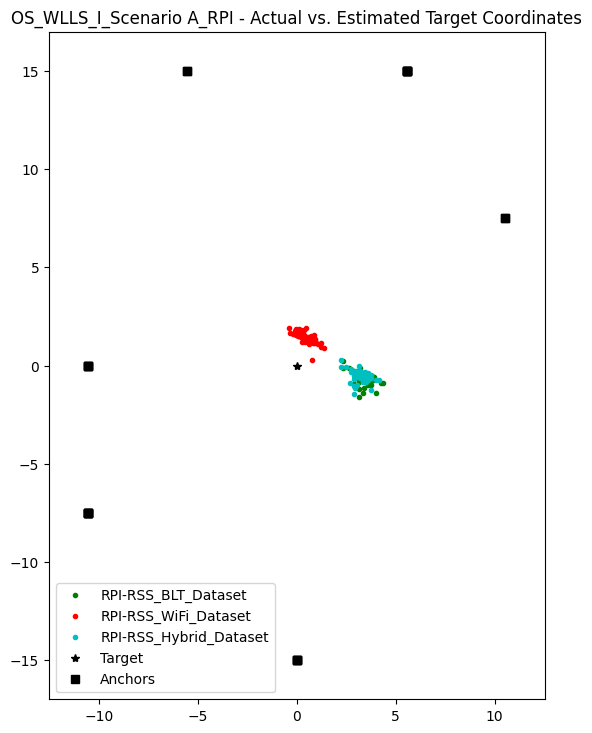

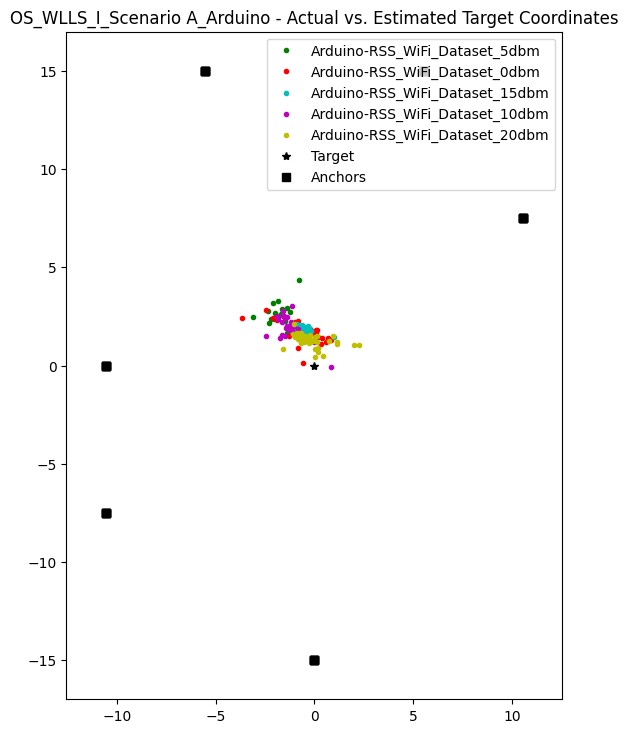

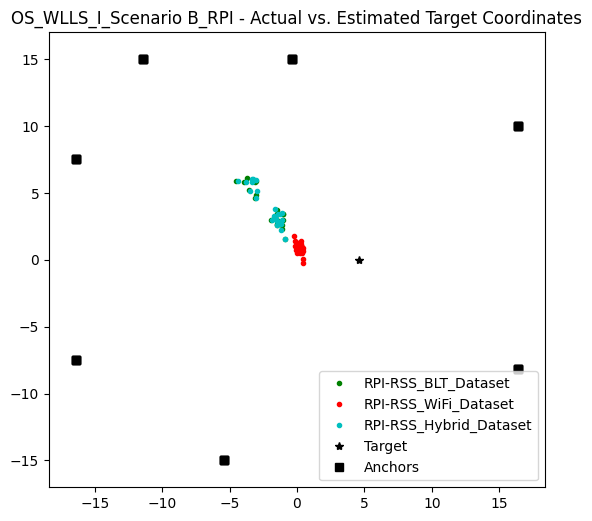

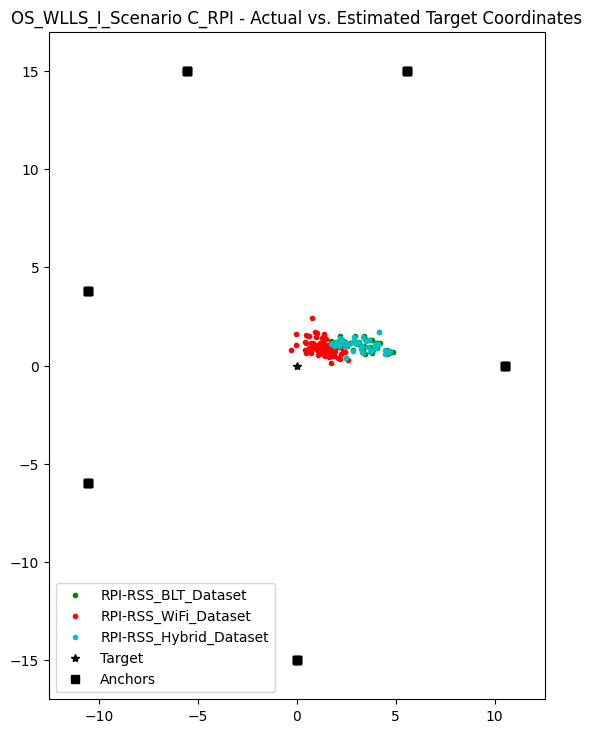

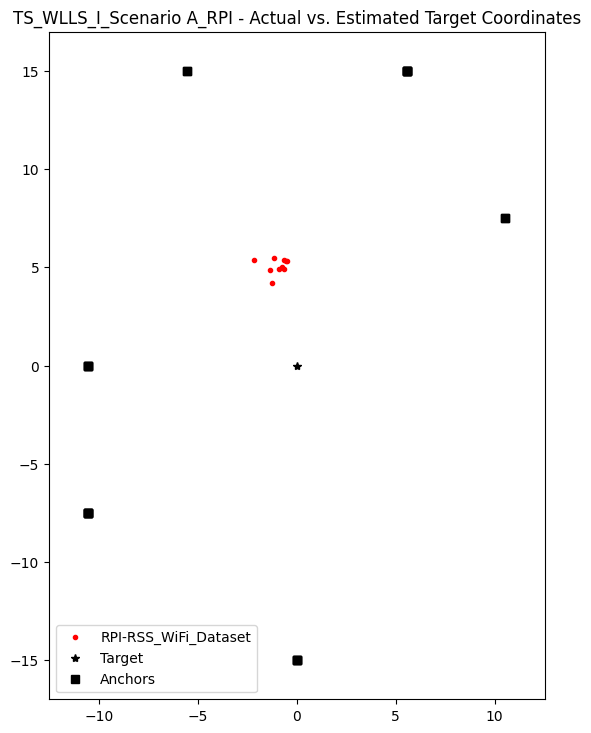

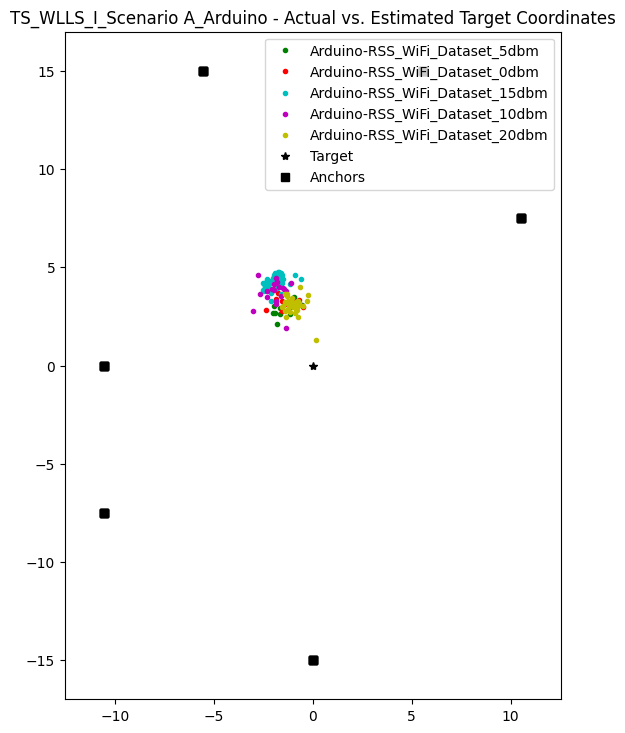

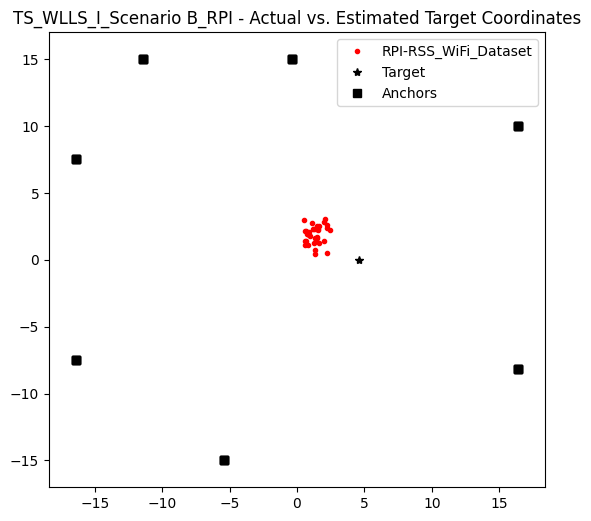

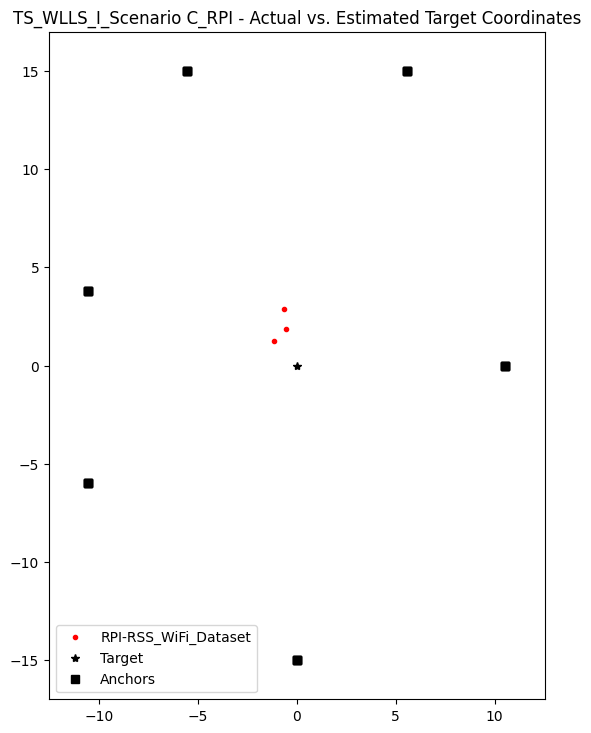

In [17]:
for estimator in data.keys():
    auxfunc.plot_data(estimator, data[estimator])